In [28]:
import os
import pickle
import shutil

import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
import cartopy.vector_transform as cvt
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from shapely import Point, Polygon
from skimage import measure, morphology

### Import RIOPS 3D temperature variable NetCDF file

In [29]:
nc_file = "20250701T00Z_MSC_RIOPS_VOTEMPER_DBS-all_PS5km_P000.nc"
if not os.path.exists(nc_file):
    shutil.copy("/data/hpfx.collab.science.gc.ca/20250701/WXO-DD/model_riops/netcdf/forecast/polar_stereographic/3d/00/000/20250701T00Z_MSC_RIOPS_VOTEMPER_DBS-all_PS5km_P000.nc", nc_file)

In [ ]:
ds = xr.open_dataset(nc_file)
ds

<xarray.Dataset> Size: 878MB
Dimensions:              (time: 1, depth: 75, yc: 1610, xc: 1770)
Coordinates:
  * xc                   (xc) float32 7kB 0.0 5e+03 1e+04 ... 8.84e+06 8.845e+06
  * yc                   (yc) float32 6kB 0.0 5e+03 1e+04 ... 8.04e+06 8.045e+06
    latitude             (yc, xc) float32 11MB ...
    longitude            (yc, xc) float32 11MB ...
  * depth                (depth) float32 300B 0.5075 1.558 ... 5.902e+03
  * time                 (time) datetime64[ns] 8B 2025-07-01
Data variables:
    polar_stereographic  |S1 1B ...
    votemper             (time, depth, yc, xc) float32 855MB ...
Attributes:
    Conventions:      CF-1.6
    title:            Instantaneous ice and ocean forecast fields
    institution:      The Canadian Centre for Meteorological and Environmenta...
    source:           Regional Ice Ocean Prediction System: version 2.4.0
    product_version:  RIOPS_2.4.0_F
    creation_date:    2025-Jul-01 06:03:16 UTC
    contact:          production-info@ec.gc.ca

### Extract perimeter from temperature data

In [8]:
# get surface level temperature data
temp = ds.votemper[0, 0, :, :].data

# create binary mask from data
binary_mask = np.where(np.isnan(temp), 0, 1)
binary_mask = np.pad(binary_mask, 1)  # pad the mask so that the edges will be included in the perimeter

# create a convex hull mask
ch_mask = morphology.convex_hull_image(binary_mask)

# pad lat and lons for indexing
pad_lat = np.pad(ds.latitude.data, 1)
pad_lon = np.pad(ds.longitude.data, 1)

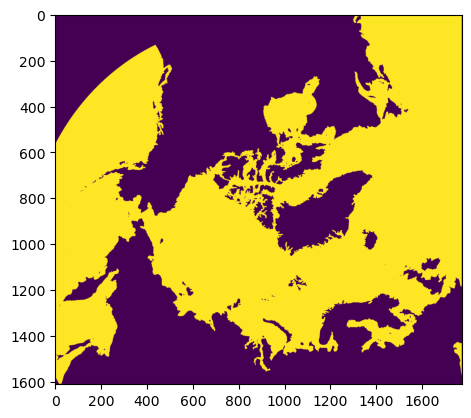

In [9]:
plt.imshow(binary_mask)

In [10]:
# get the contours from the mask
contours = measure.find_contours(ch_mask, level=0)

# select the first contour for our perimeter (the first element should be the one we're interested in but you'll have to confirm yourself)
perim_y, perim_x = np.transpose(contours[0]).astype(int)

# shift coordinates on array edges so that we're not selecting the padded portion
height, width = ch_mask.shape

perim_y[perim_y == 0] = 1
perim_y[perim_y >= height - 1] = height - 2

perim_x[perim_x == 0] = 1
perim_x[perim_x >= width - 1] = width - 2

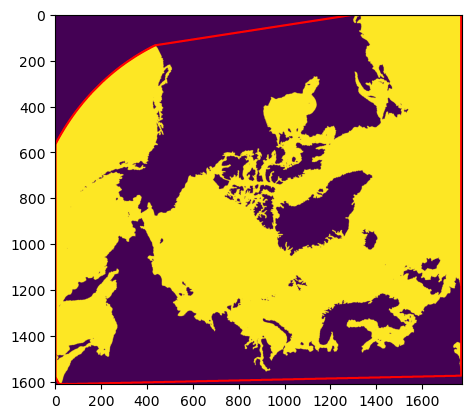

In [11]:
# plotting to confirm the indices are accurate
plt.figure()
plt.imshow(binary_mask)
plt.plot(perim_x, perim_y, color="red")

In [12]:
# Select that actual lon lat values
perim_lat = pad_lat[perim_y, perim_x]
perim_lon = pad_lon[perim_y, perim_x]

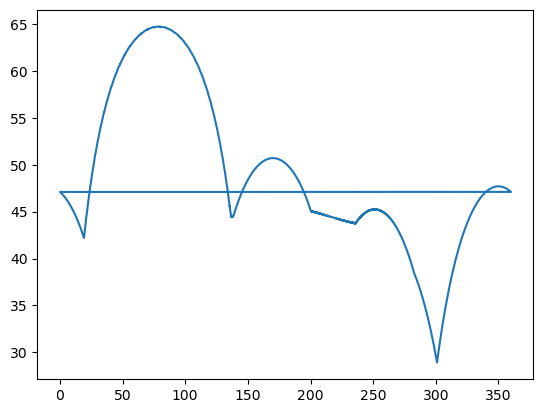

In [13]:
# Check to see that the resulting polygon does not intersect iself.
# If it does then it will not work for checking if it contains points
plt.plot(perim_lon, perim_lat)

Our polygon self-intersects where it crosses the prime meridian. For datasets that don't span all longitude values you might be able cast the longitude to -180 180 and resort the data to avoid this but that's not an option here. To fix this we can insert points at (0, 90) and (360, 90) to enclose the area. We just need to find the indices of this intersection so that we can insert these points in the right place.

In [14]:
# find the index where longitdue jumps from ~360 to ~0
idx = np.argmax(np.abs(np.diff(perim_lon)))  # calculates the difference between adjacent points and returns the index of the biggest one
print(perim_lon[idx], perim_lon[idx + 1])  # print the lon values to verify index is correct

# insert new points in both arrays
new_lons = [360, 360, 0, 0]
new_lats = [perim_lat[idx], 90, 90, perim_lat[idx + 1]]
perim_lon = np.insert(perim_lon, idx + 1, new_lons)
perim_lat = np.insert(perim_lat, idx + 1, new_lats)

359.98523 0.04563


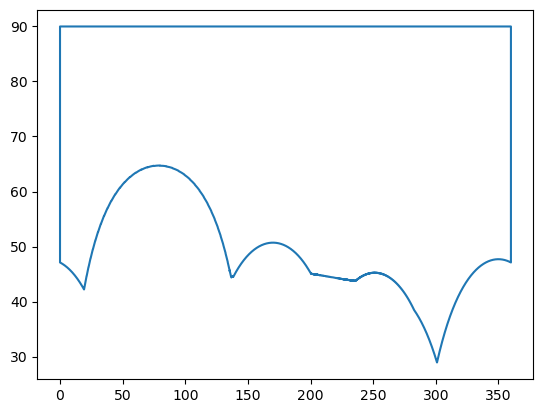

In [15]:
# Now we should have a non-intersecting perimeter polygon
plt.plot(perim_lon, perim_lat)

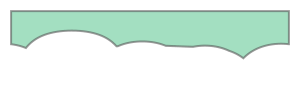

In [16]:
perim_poly = np.stack([perim_lon, perim_lat], axis=1)
perim_poly = Polygon(perim_poly)
perim_poly

In [17]:
with open("riops_poly.pkl", "wb") as f:
    pickle.dump(perim_poly, f)

### Plot the results to verify

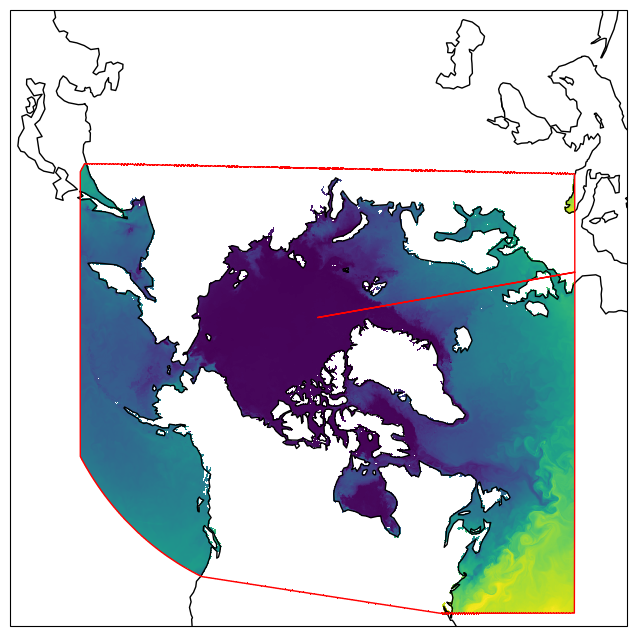

In [18]:
# The dataset uses a polar steoraphc grid and its parameters are kept as attributes in the polar_stereographic variable.
# Create a polar stereographic CRS object to plot the data natively - PlateCarree would probably be fine for most other grids. 
polar_stereo = ccrs.NorthPolarStereo(
    central_longitude=ds.polar_stereographic.attrs[
        "straight_vertical_longitude_from_pole"
    ]
)

# Get lat/lon values to plot data iwth
lon = ds.longitude.data
lat = ds.latitude.data

# Create plot figure with polar stereographic projection
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=polar_stereo)

# Create a mesh for the temperature data by transforming it from lat lon coordinates to polar sterographic
mesh = ax.pcolormesh(
    lon,
    lat,
    temp,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    shading="auto",
)

ax.coastlines()
ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())

# plot perimeter
# ax.plot(perim_lon, perim_lat, transform=ccrs.PlateCarree(), color="red")
ax.add_geometries([perim_poly], crs=ccrs.PlateCarree(), facecolor=(0,0,0,0), edgecolor='red',)

plt.show()

###

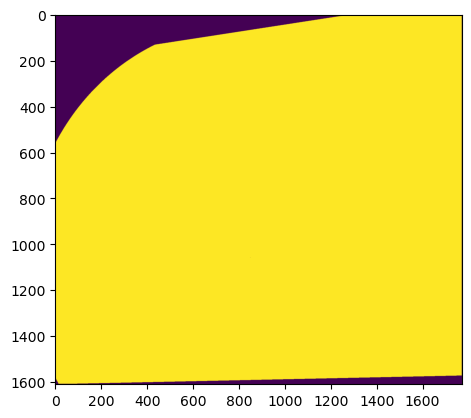

In [19]:
# Test that the polygon contains method works using the dataset lat/lon values
# Runs very slowly 
ni, nj = ds.longitude.shape
poly_mask = np.zeros((ni,nj))

for i in range(ni):
    for j in range(nj):
        pt = Point(ds.longitude.data[i,j], ds.latitude.data[i,j])
        if perim_poly.contains(pt):
            poly_mask[i,j] = 1

plt.imshow(poly_mask)

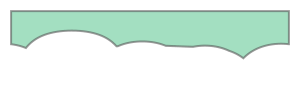

In [20]:
with open("riops_poly.pkl", "rb") as f:
    poly = pickle.load(f)
poly